In [2]:
# Straight from docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html



# Tutorial 3: Train SimCLR on Clothing

In this tutorial, we will train a SimCLR model using lightly. The model,
augmentations and training procedure is from 
[A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/abs/2002.05709).

The paper explores a rather simple training procedure for contrastive learning.
Since we use the typical contrastive learning loss based on NCE the method
greatly benefits from having larger batch sizes. In this example, we use a batch
size of 256 and paired with the input resolution per image of 64x64 pixels and
a resnet-18 model this example requires 16GB of GPU memory.

We use the 
[clothing dataset from Alex Grigorev](https://github.com/alexeygrigorev/clothing-dataset) 
for this tutorial.

In this tutorial you will learn:

- How to create a SimCLR model

- How to generate image representations

- How different augmentations impact the learned representations


## Imports

Import the Python frameworks we need for this tutorial.



In [27]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import pandas as pd
from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

from utils import (
    generate_embeddings_and_fnames,
    get_image_as_np_array,
    plot_knn_clusters,
    get_distance_between_points_in_cluster,
    get_distances_between_centroids,
    plot_clusters,
    generate_embeddings_and_fnames_simclr,
    check_labels_correspondence,
    plot_knn_examples,
)

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [4]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 10
input_size = 128
num_ftrs = 32

Let's set the seed for our experiments



In [5]:
pl.seed_everything(seed)

Seed set to 1


1

Make sure `path_to_data` points to the downloaded clothing dataset.
You can download it using
`git clone https://github.com/alexeygrigorev/clothing-dataset.git`


In [6]:
path_to_data = r"D:\__repos\ml_concepts\ideas\ssl\datasets\clothing-dataset\images"

## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [7]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [8]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [9]:
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_prec

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [10]:
model.eval()
embeddings, filenames = generate_embeddings_and_fnames(model, dataloader_test)

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



Let's do the plot of the images. The leftmost image is the query image whereas
the ones next to it on the same row are the nearest neighbors.
In the title we see the distance of the neigbor.



d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid

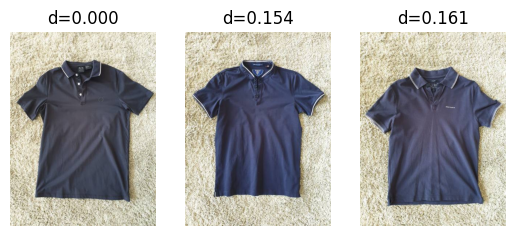

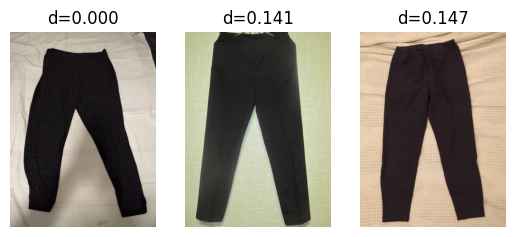

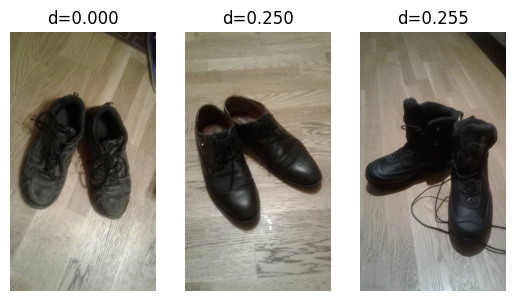

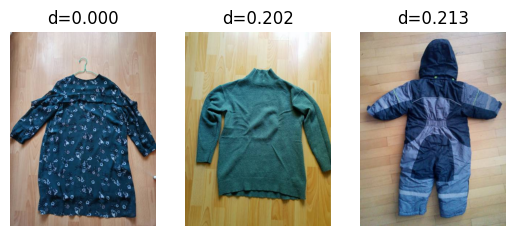

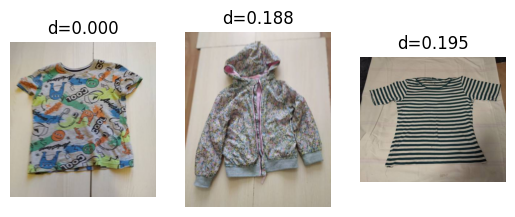

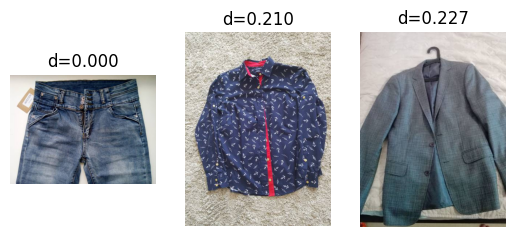

In [11]:
plot_knn_examples(embeddings, filenames, path_to_data=path_to_data)

## Color Invariance
Let's train again without color augmentation. This will force our model to
respect the colors in the images.



In [12]:
# Set color jitter and gray scale probability to 0
new_transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# let's update the transform on the training dataset
dataset_train_simclr.transform = new_transform

# then train a new model
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

# and generate again embeddings from the test set
model.eval()
embeddings, filenames = generate_embeddings_and_fnames(model, dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (22) is smal

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


other example



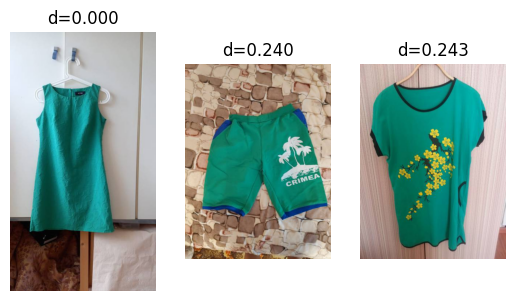

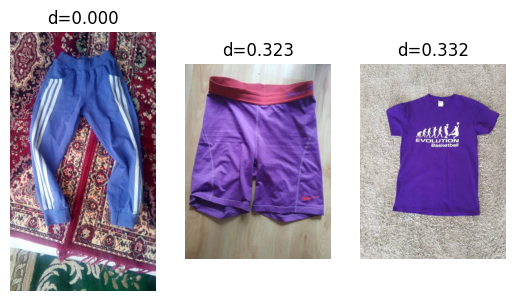

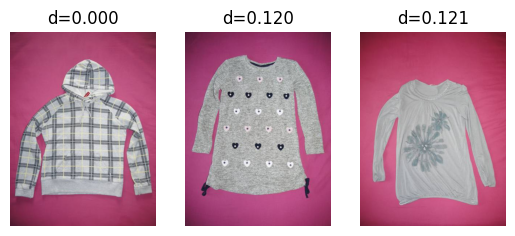

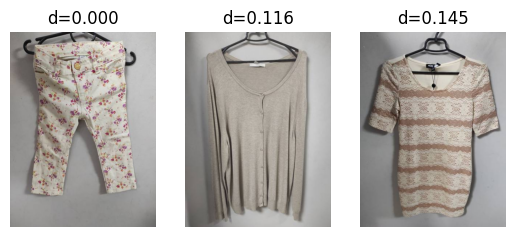

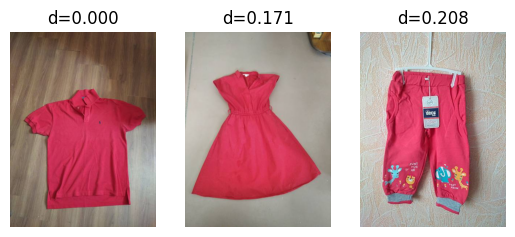

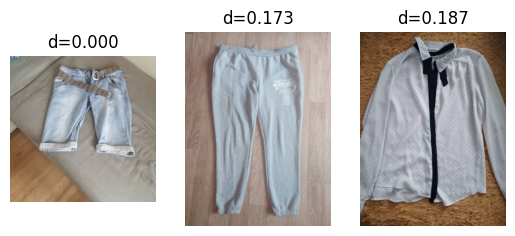

In [13]:
plot_knn_examples(embeddings, filenames, path_to_data=path_to_data)

In [14]:
distances = get_distances_between_centroids(embeddings)

Cluster centroids dimensions: (10, 512)
Cluster centroids:
 [[0.02981041 0.00951674 0.0085925  ... 0.00938724 0.01089731 0.06293075]
 [0.04188623 0.00255558 0.0095241  ... 0.0452273  0.04132988 0.04011433]
 [0.01106755 0.01450668 0.01980626 ... 0.03276136 0.01804152 0.00824373]
 ...
 [0.06067342 0.015006   0.01152036 ... 0.00666193 0.00423325 0.06818991]
 [0.0410191  0.06291339 0.01854761 ... 0.0139048  0.03020106 0.03072763]
 [0.03096377 0.01149729 0.00914531 ... 0.03329841 0.01434807 0.03827805]]
Cluster sizes: [800 277 763 413 576 759 748 321 673 426]


In [15]:
print(f"Distances shape: {distances.shape}")
print(f"Distances rank: {np.linalg.matrix_rank(distances)}")
print(f"Distancess:\n {distances}")

Distances shape: (10, 10)
Distances rank: 10
Distancess:
 [[0.         0.81829312 0.63696284 0.65779332 0.91096807 0.85656622
  0.48753097 0.67699436 0.54774179 0.70386493]
 [0.81829312 0.         0.78369904 0.50300492 0.65430349 0.80431153
  0.74199558 0.5624208  0.7719127  0.6334108 ]
 [0.63696284 0.78369904 0.         0.83818428 0.86326455 0.59874779
  0.57393966 0.83379533 0.73245379 0.66900165]
 [0.65779332 0.50300492 0.83818428 0.         0.82999527 0.9295481
  0.63178252 0.46405032 0.76006703 0.65044613]
 [0.91096807 0.65430349 0.86326455 0.82999527 0.         0.63449037
  0.8280843  0.77224933 0.67403509 0.84288695]
 [0.85656622 0.80431153 0.59874779 0.9295481  0.63449037 0.
  0.75476494 0.86548106 0.72322481 0.84867649]
 [0.48753097 0.74199558 0.57393966 0.63178252 0.8280843  0.75476494
  0.         0.66407457 0.63383475 0.67592237]
 [0.67699436 0.5624208  0.83379533 0.46405032 0.77224933 0.86548106
  0.66407457 0.         0.68332161 0.65996485]
 [0.54774179 0.7719127  0.73245

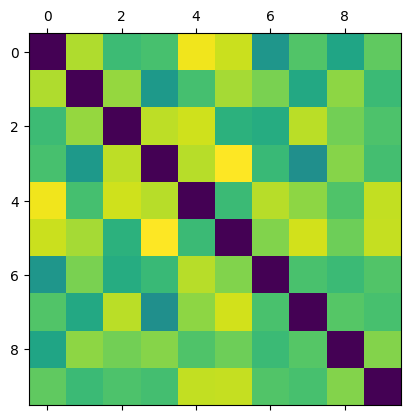

In [16]:
plt.matshow(distances, cmap="viridis")

In [17]:
visualization_df = pd.DataFrame(distances)
print(visualization_df)

          0         1         2         3         4         5         6  \
0  0.000000  0.818293  0.636963  0.657793  0.910968  0.856566  0.487531   
1  0.818293  0.000000  0.783699  0.503005  0.654303  0.804312  0.741996   
2  0.636963  0.783699  0.000000  0.838184  0.863265  0.598748  0.573940   
3  0.657793  0.503005  0.838184  0.000000  0.829995  0.929548  0.631783   
4  0.910968  0.654303  0.863265  0.829995  0.000000  0.634490  0.828084   
5  0.856566  0.804312  0.598748  0.929548  0.634490  0.000000  0.754765   
6  0.487531  0.741996  0.573940  0.631783  0.828084  0.754765  0.000000   
7  0.676994  0.562421  0.833795  0.464050  0.772249  0.865481  0.664075   
8  0.547742  0.771913  0.732454  0.760067  0.674035  0.723225  0.633835   
9  0.703865  0.633411  0.669002  0.650446  0.842887  0.848676  0.675922   

          7         8         9  
0  0.676994  0.547742  0.703865  
1  0.562421  0.771913  0.633411  
2  0.833795  0.732454  0.669002  
3  0.464050  0.760067  0.650446  
4  0

In [18]:
plot_knn_clusters(
    embeddings, np.array(dataset_test.dataset.targets), n_neighbors=5, num_examples=10
)

Indices shape: (5756, 5)
Sampled indices: [ 841 4977 5314 2387 2221 1768 3614 1955 3662 4425]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]
Original label: 0
Predicted label: [0 0 0 0 0]


In [38]:
proportion_of_points_to_plot = 0.4
num_clusters = 20
alpha = 0.3

In [39]:
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_

In [40]:
sampled_indices = np.random.choice(
    embeddings.shape[0],
    int(len(embeddings) * proportion_of_points_to_plot),
    replace=False,
)

In [50]:
%matplotlib widget

Plotting 2302 points out of 5756
PCA(n_components=3)
(2302, 3)
(20, 3)


C:\Users\Maciek\AppData\Local\Temp\ipykernel_16004\62715347.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


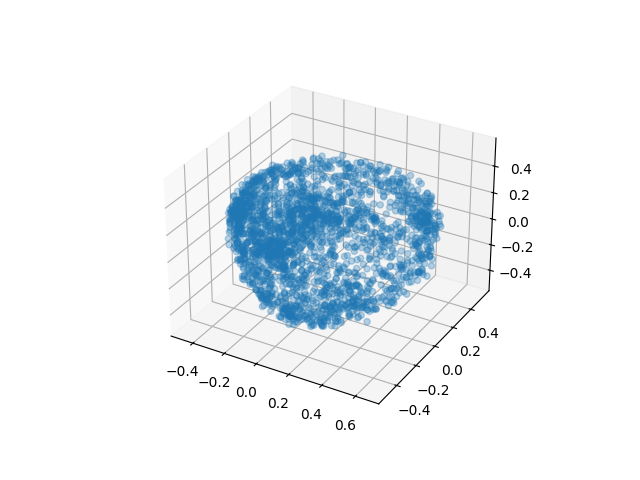

In [51]:
sampled_embeddings = embeddings[sampled_indices]

print(f"Plotting {len(sampled_embeddings)} points out of {len(embeddings)}")

ax = plt.figure().add_subplot(projection="3d")

pca = PCA(n_components=3)
print(pca)

to_plot_embeddings = pca.fit_transform(sampled_embeddings)
print(to_plot_embeddings.shape)

to_plot_centroids = pca.transform(centroids)
print(to_plot_centroids.shape)

ax.scatter(
    to_plot_embeddings[:, 0],
    to_plot_embeddings[:, 1],
    to_plot_embeddings[:, 2],
    alpha=alpha,
    cmap="viridis",
)

plt.show()

What's next?



In [19]:
# You could use the pre-trained model and train a classifier on top.
pretrained_resnet_backbone = model.backbone

# you can also store the backbone and use it in another code
state_dict = {"resnet18_parameters": pretrained_resnet_backbone.state_dict()}
torch.save(state_dict, "model.pth")

THIS COULD BE IN A NEW FILE (e.g. inference.py)

Make sure you place the `model.pth` file in the same folder as this code



In [20]:
# load the model in a new file for inference
resnet18_new = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])

ckpt = torch.load("model.pth")
backbone_new.load_state_dict(ckpt["resnet18_parameters"])

<All keys matched successfully>

## Next Steps

Interested in exploring other self-supervised models? Check out our other
tutorials:

- `lightly-moco-tutorial-2`
- `lightly-simsiam-tutorial-4`
- `lightly-custom-augmentation-5`
- `lightly-detectron-tutorial-6`


